# Machine Learning models of neural activity

In [ ]:
# spectro-temporal receptive field (STRF) f estimation on continous data

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import mne
from mne.decoding import ReceptiveField, TimeDelayingRidge

from scipy.stats import multivariate_normal
from scipy.io import loadmat
from sklearn.preprocessing import scale
rng = np.random.RandomState(1337)  # To make this example reproducible

In [2]:
# load audio data

# Read in audio that's been recorded in epochs.
path_audio = mne.datasets.mtrf.data_path()
data = loadmat(str(path_audio / 'speech_data.mat'))
audio = data['spectrogram'].T
sfreq = float(data['Fs'][0, 0])
n_decim = 2
audio = mne.filter.resample(audio, down=n_decim, npad='auto')
sfreq /= n_decim

Using default location ~/mne_data for mtrf...


100%|█████████████████████████████████████| 58.1M/58.1M [00:00<00:00, 50.5GB/s]
Unzipping contents of '/Users/DanDan/mne_data/mTRF_1.5.zip' to '/Users/DanDan/mne_data'


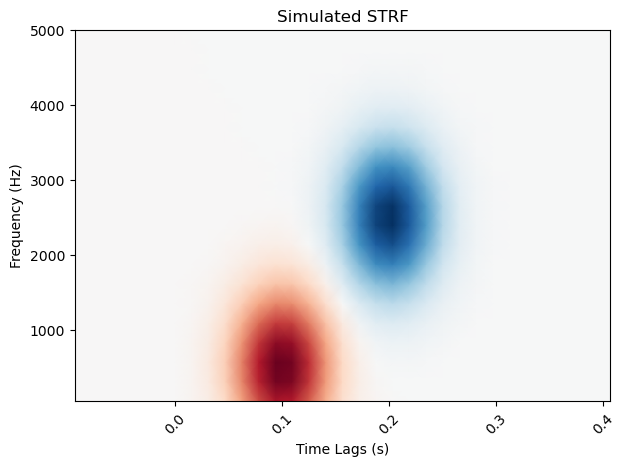

In [3]:
# receptive field

n_freqs = 20
tmin, tmax = -0.1, 0.4

# To simulate the data we'll create explicit delays here
delays_samp = np.arange(np.round(tmin * sfreq),
                        np.round(tmax * sfreq) + 1).astype(int)
delays_sec = delays_samp / sfreq
freqs = np.linspace(50, 5000, n_freqs)
grid = np.array(np.meshgrid(delays_sec, freqs))

# We need data to be shaped as n_epochs, n_features, n_times, so swap axes here
grid = grid.swapaxes(0, -1).swapaxes(0, 1)

# Simulate a temporal receptive field with a Gabor filter
means_high = [.1, 500]
means_low = [.2, 2500]
cov = [[.001, 0], [0, 500000]]
gauss_high = multivariate_normal.pdf(grid, means_high, cov)
gauss_low = -1 * multivariate_normal.pdf(grid, means_low, cov)
weights = gauss_high + gauss_low  # Combine to create the "true" STRF
kwargs = dict(vmax=np.abs(weights).max(), vmin=-np.abs(weights).max(),
              cmap='RdBu_r', shading='gouraud')

fig, ax = plt.subplots()
ax.pcolormesh(delays_sec, freqs, weights, **kwargs)
ax.set(title='Simulated STRF', xlabel='Time Lags (s)', ylabel='Frequency (Hz)')
plt.setp(ax.get_xticklabels(), rotation=45)
plt.autoscale(tight=True)
mne.viz.tight_layout()

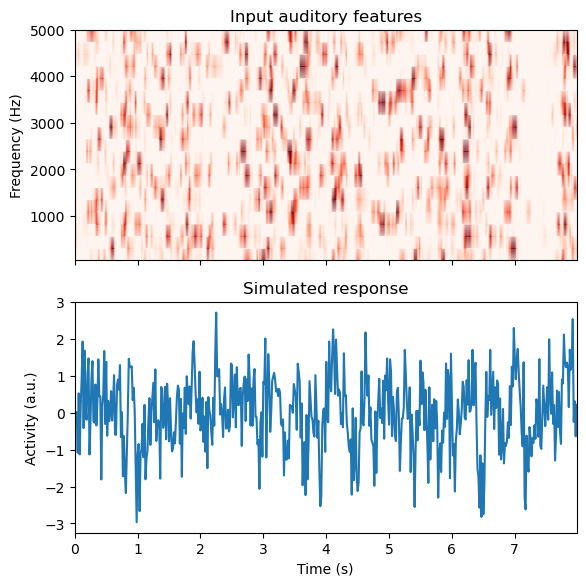

In [4]:
# Reshape audio to split into epochs, then make epochs the first dimension.
n_epochs, n_seconds = 16, 5
audio = audio[:, :int(n_seconds * sfreq * n_epochs)]
X = audio.reshape([n_freqs, n_epochs, -1]).swapaxes(0, 1)
n_times = X.shape[-1]

# Delay the spectrogram according to delays so it can be combined w/ the STRF
# Lags will now be in axis 1, then we reshape to vectorize
delays = np.arange(np.round(tmin * sfreq),
                   np.round(tmax * sfreq) + 1).astype(int)

# Iterate through indices and append
X_del = np.zeros((len(delays),) + X.shape)
for ii, ix_delay in enumerate(delays):
    # These arrays will take/put particular indices in the data
    take = [slice(None)] * X.ndim
    put = [slice(None)] * X.ndim
    if ix_delay > 0:
        take[-1] = slice(None, -ix_delay)
        put[-1] = slice(ix_delay, None)
    elif ix_delay < 0:
        take[-1] = slice(-ix_delay, None)
        put[-1] = slice(None, ix_delay)
    X_del[ii][tuple(put)] = X[tuple(take)]

# Now set the delayed axis to the 2nd dimension
X_del = np.rollaxis(X_del, 0, 3)
X_del = X_del.reshape([n_epochs, -1, n_times])
n_features = X_del.shape[1]
weights_sim = weights.ravel()

# Simulate a neural response to the sound, given this STRF
y = np.zeros((n_epochs, n_times))
for ii, iep in enumerate(X_del):
    # Simulate this epoch and add random noise
    noise_amp = .002
    y[ii] = np.dot(weights_sim, iep) + noise_amp * rng.randn(n_times)

# Plot the first 2 trials of audio and the simulated electrode activity
X_plt = scale(np.hstack(X[:2]).T).T
y_plt = scale(np.hstack(y[:2]))
time = np.arange(X_plt.shape[-1]) / sfreq
_, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6), sharex=True)
ax1.pcolormesh(time, freqs, X_plt, vmin=0, vmax=4, cmap='Reds',
               shading='gouraud')
ax1.set_title('Input auditory features')
ax1.set(ylim=[freqs.min(), freqs.max()], ylabel='Frequency (Hz)')
ax2.plot(time, y_plt)
ax2.set(xlim=[time.min(), time.max()], title='Simulated response',
        xlabel='Time (s)', ylabel='Activity (a.u.)')
mne.viz.tight_layout()

fit a model to recover this receptive field

Fitting 15 epochs, 20 channels


  0%|          | Sample : 0/3450 [00:00<?,       ?it/s]

Fitting 15 epochs, 20 channels


  0%|          | Sample : 0/3450 [00:00<?,       ?it/s]

Fitting 15 epochs, 20 channels


  0%|          | Sample : 0/3450 [00:00<?,       ?it/s]

Fitting 15 epochs, 20 channels


  0%|          | Sample : 0/3450 [00:00<?,       ?it/s]

Fitting 15 epochs, 20 channels


  0%|          | Sample : 0/3450 [00:00<?,       ?it/s]

Fitting 15 epochs, 20 channels


  0%|          | Sample : 0/3450 [00:00<?,       ?it/s]

Fitting 15 epochs, 20 channels


  0%|          | Sample : 0/3450 [00:00<?,       ?it/s]

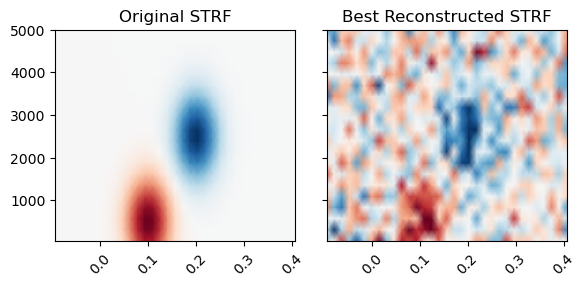

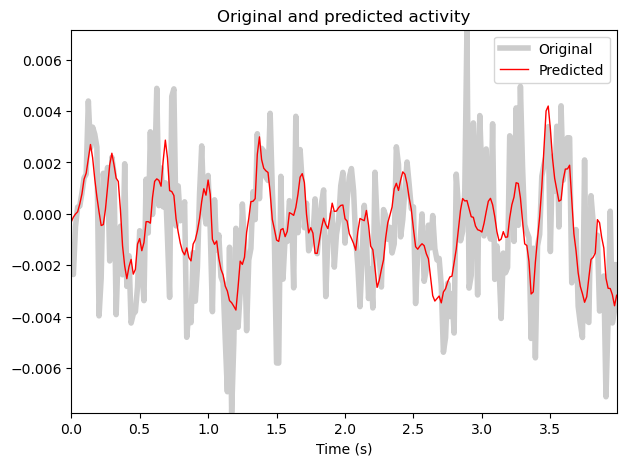

In [6]:
# Create training and testing data
train, test = np.arange(n_epochs - 1), n_epochs - 1
X_train, X_test, y_train, y_test = X[train], X[test], y[train], y[test]
X_train, X_test, y_train, y_test = [np.rollaxis(ii, -1, 0) for ii in
                                    (X_train, X_test, y_train, y_test)]
# Model the simulated data as a function of the spectrogram input
alphas = np.logspace(-3, 3, 7)
scores = np.zeros_like(alphas)
models = []
for ii, alpha in enumerate(alphas):
    rf = ReceptiveField(tmin, tmax, sfreq, freqs, estimator=alpha)
    rf.fit(X_train, y_train)

    # Now make predictions about the model output, given input stimuli.
    scores[ii] = rf.score(X_test, y_test)
    models.append(rf)

times = rf.delays_ / float(rf.sfreq)

# Choose the model that performed best on the held out data
ix_best_alpha = np.argmax(scores)
best_mod = models[ix_best_alpha]
coefs = best_mod.coef_[0]
best_pred = best_mod.predict(X_test)[:, 0]

# Plot the original STRF, and the one that we recovered with modeling.
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3), sharey=True, sharex=True)
ax1.pcolormesh(delays_sec, freqs, weights, **kwargs)
ax2.pcolormesh(times, rf.feature_names, coefs, **kwargs)
ax1.set_title('Original STRF')
ax2.set_title('Best Reconstructed STRF')
plt.setp([iax.get_xticklabels() for iax in [ax1, ax2]], rotation=45)
plt.autoscale(tight=True)
mne.viz.tight_layout()

# Plot the actual response and the predicted response on a held out stimulus
time_pred = np.arange(best_pred.shape[0]) / sfreq
fig, ax = plt.subplots()
ax.plot(time_pred, y_test, color='k', alpha=.2, lw=4)
ax.plot(time_pred, best_pred, color='r', lw=1)
ax.set(title='Original and predicted activity', xlabel='Time (s)')
ax.legend(['Original', 'Predicted'])
plt.autoscale(tight=True)
mne.viz.tight_layout()

standarded regularizaiton

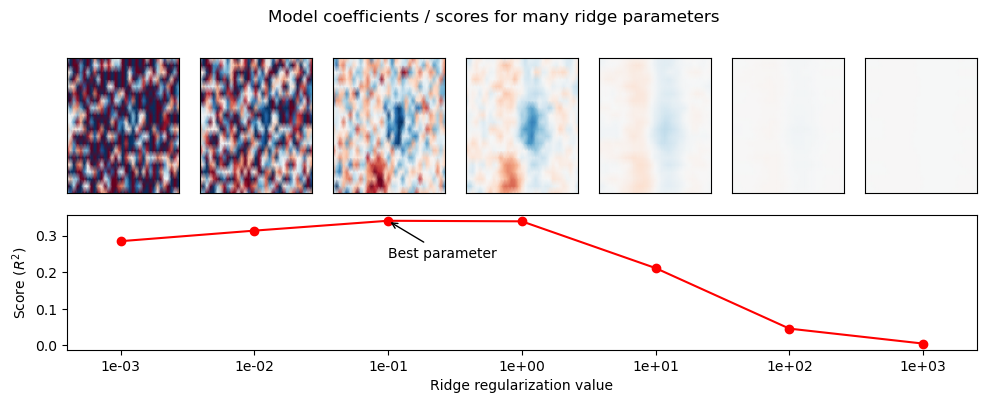

In [10]:
# visualize the effects of regularization


# Plot model score for each ridge parameter
fig = plt.figure(figsize=(10, 4))
ax = plt.subplot2grid([2, len(alphas)], [1, 0], 1, len(alphas))
ax.plot(np.arange(len(alphas)), scores, marker='o', color='r')
ax.annotate('Best parameter', (ix_best_alpha, scores[ix_best_alpha]),
            (ix_best_alpha, scores[ix_best_alpha] - .1),
            arrowprops={'arrowstyle': '->'})
plt.xticks(np.arange(len(alphas)), ["%.0e" % ii for ii in alphas])
ax.set(xlabel="Ridge regularization value", ylabel="Score ($R^2$)",
       xlim=[-.4, len(alphas) - .6])
mne.viz.tight_layout()

# Plot the STRF of each ridge parameter
for ii, (rf, i_alpha) in enumerate(zip(models, alphas)):
    ax = plt.subplot2grid([2, len(alphas)], [0, ii], 1, 1)
    ax.pcolormesh(times, rf.feature_names, rf.coef_[0], **kwargs)
    plt.xticks([], [])
    plt.yticks([], [])
    plt.autoscale(tight=True)
fig.suptitle('Model coefficients / scores for many ridge parameters', y=1)
mne.viz.tight_layout()

Laplacian regularization

In [11]:
scores_lap = np.zeros_like(alphas)
models_lap = []
for ii, alpha in enumerate(alphas):
    estimator = TimeDelayingRidge(tmin, tmax, sfreq, reg_type='laplacian',
                                  alpha=alpha)
    rf = ReceptiveField(tmin, tmax, sfreq, freqs, estimator=estimator)
    rf.fit(X_train, y_train)

    # Now make predictions about the model output, given input stimuli.
    scores_lap[ii] = rf.score(X_test, y_test)
    models_lap.append(rf)

ix_best_alpha_lap = np.argmax(scores_lap)

Fitting 15 epochs, 20 channels


  0%|          | Sample : 0/3450 [00:00<?,       ?it/s]

Fitting 15 epochs, 20 channels


  0%|          | Sample : 0/3450 [00:00<?,       ?it/s]

Fitting 15 epochs, 20 channels


  0%|          | Sample : 0/3450 [00:00<?,       ?it/s]

Fitting 15 epochs, 20 channels


  0%|          | Sample : 0/3450 [00:00<?,       ?it/s]

Fitting 15 epochs, 20 channels


  0%|          | Sample : 0/3450 [00:00<?,       ?it/s]

Fitting 15 epochs, 20 channels


  0%|          | Sample : 0/3450 [00:00<?,       ?it/s]

Fitting 15 epochs, 20 channels


  0%|          | Sample : 0/3450 [00:00<?,       ?it/s]

compare model performance

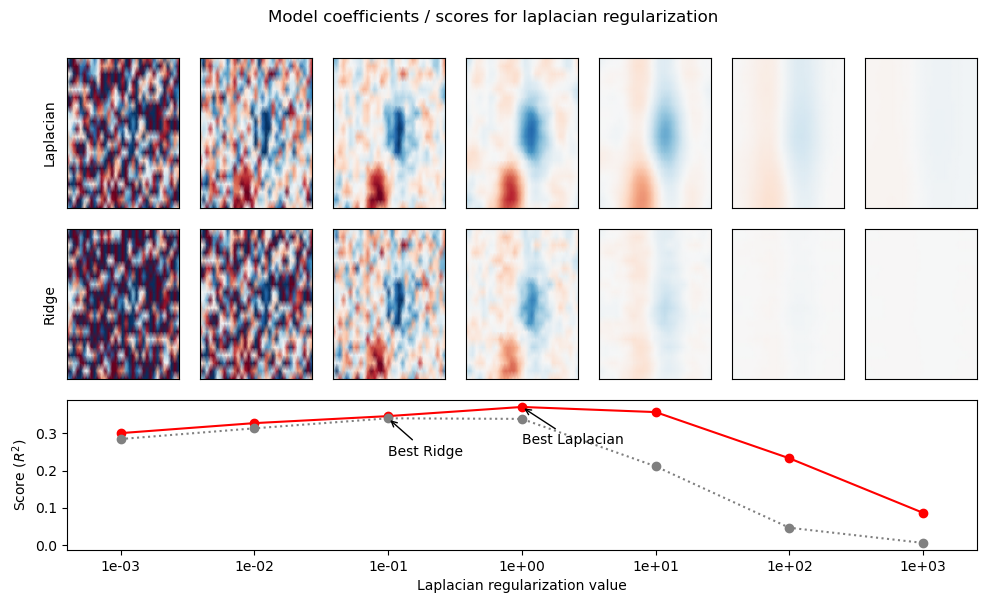

In [12]:
fig = plt.figure(figsize=(10, 6))
ax = plt.subplot2grid([3, len(alphas)], [2, 0], 1, len(alphas))
ax.plot(np.arange(len(alphas)), scores_lap, marker='o', color='r')
ax.plot(np.arange(len(alphas)), scores, marker='o', color='0.5', ls=':')
ax.annotate('Best Laplacian', (ix_best_alpha_lap,
                               scores_lap[ix_best_alpha_lap]),
            (ix_best_alpha_lap, scores_lap[ix_best_alpha_lap] - .1),
            arrowprops={'arrowstyle': '->'})
ax.annotate('Best Ridge', (ix_best_alpha, scores[ix_best_alpha]),
            (ix_best_alpha, scores[ix_best_alpha] - .1),
            arrowprops={'arrowstyle': '->'})
plt.xticks(np.arange(len(alphas)), ["%.0e" % ii for ii in alphas])
ax.set(xlabel="Laplacian regularization value", ylabel="Score ($R^2$)",
       xlim=[-.4, len(alphas) - .6])
mne.viz.tight_layout()

# Plot the STRF of each ridge parameter
xlim = times[[0, -1]]
for ii, (rf_lap, rf, i_alpha) in enumerate(zip(models_lap, models, alphas)):
    ax = plt.subplot2grid([3, len(alphas)], [0, ii], 1, 1)
    ax.pcolormesh(times, rf_lap.feature_names, rf_lap.coef_[0], **kwargs)
    ax.set(xticks=[], yticks=[], xlim=xlim)
    if ii == 0:
        ax.set(ylabel='Laplacian')
    ax = plt.subplot2grid([3, len(alphas)], [1, ii], 1, 1)
    ax.pcolormesh(times, rf.feature_names, rf.coef_[0], **kwargs)
    ax.set(xticks=[], yticks=[], xlim=xlim)
    if ii == 0:
        ax.set(ylabel='Ridge')
fig.suptitle('Model coefficients / scores for laplacian regularization', y=1)
mne.viz.tight_layout()

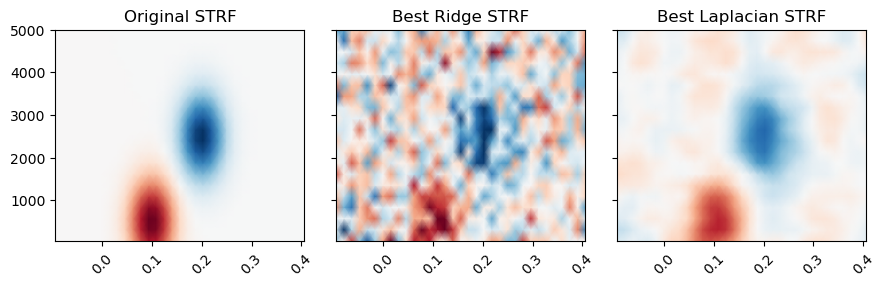

In [13]:
rf = models[ix_best_alpha]
rf_lap = models_lap[ix_best_alpha_lap]
_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 3),
                                  sharey=True, sharex=True)
ax1.pcolormesh(delays_sec, freqs, weights, **kwargs)
ax2.pcolormesh(times, rf.feature_names, rf.coef_[0], **kwargs)
ax3.pcolormesh(times, rf_lap.feature_names, rf_lap.coef_[0], **kwargs)
ax1.set_title('Original STRF')
ax2.set_title('Best Ridge STRF')
ax3.set_title('Best Laplacian STRF')
plt.setp([iax.get_xticklabels() for iax in [ax1, ax2, ax3]], rotation=45)
plt.autoscale(tight=True)
mne.viz.tight_layout()

## decoding (MVPA)

In [14]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

import mne
from mne.datasets import sample
from mne.decoding import (SlidingEstimator, GeneralizingEstimator, Scaler,
                          cross_val_multiscore, LinearModel, get_coef,
                          Vectorizer, CSP)

data_path = sample.data_path()

subjects_dir = data_path / 'subjects'
meg_path = data_path / 'MEG' / 'sample'
raw_fname = meg_path / 'sample_audvis_filt-0-40_raw.fif'
tmin, tmax = -0.200, 0.500
event_id = {'Auditory/Left': 1, 'Visual/Left': 3}  # just use two
raw = mne.io.read_raw_fif(raw_fname)
raw.pick_types(meg='grad', stim=True, eog=True, exclude=())

# The subsequent decoding analyses only capture evoked responses, so we can
# low-pass the MEG data. Usually a value more like 40 Hz would be used,
# but here low-pass at 20 so we can more heavily decimate, and allow
# the example to run faster. The 2 Hz high-pass helps improve CSP.
raw.load_data().filter(2, 20)
events = mne.find_events(raw, 'STI 014')

# Set up bad channels (modify to your needs)
raw.info['bads'] += ['MEG 2443']  # bads + 2 more

# Read epochs
epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=True,
                    picks=('grad', 'eog'), baseline=(None, 0.), preload=True,
                    reject=dict(grad=4000e-13, eog=150e-6), decim=3,
                    verbose='error')
epochs.pick_types(meg=True, exclude='bads')  # remove stim and EOG
del raw

X = epochs.get_data()  # MEG signals: n_epochs, n_meg_channels, n_times
y = epochs.events[:, 2]  # target: auditory left vs visual left

Opening raw data file /Users/DanDan/mne_data/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
Removing projector <Projection | PCA-v1, active : False, n_channels : 102>
Removing projector <Projection | PCA-v2, active : False, n_channels : 102>
Removing projector <Projection | PCA-v3, active : False, n_channels : 102>
Removing projector <Projection | Average EEG reference, active : False, n_channels : 60>
Reading 0 ... 41699  =      0.000 ...   277.709 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ri

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


319 events found
Event IDs: [ 1  2  3  4  5 32]


[Parallel(n_jobs=1)]: Done 204 out of 204 | elapsed:    0.6s finished


In [19]:
# transformation classes

# scaler

# Uses all MEG sensors and time points as separate classification
# features, so the resulting filters used are spatio-temporal
clf = make_pipeline(
    Scaler(epochs.info),
    Vectorizer(),
    LogisticRegression(solver='liblinear')  # liblinear is faster than lbfgs
)

scores = cross_val_multiscore(clf, X, y, cv=5, n_jobs=None)

# Mean scores across cross-validation splits
score = np.mean(scores, axis=0)
print('Spatio-temporal: %0.1f%%' % (100 * score,))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.7s remaining:    0.0s


Spatio-temporal: 99.2%


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s finished


In [20]:
csp = CSP(n_components=3, norm_trace=False)
clf_csp = make_pipeline(
    csp,
    LinearModel(LogisticRegression(solver='liblinear'))
)
scores = cross_val_multiscore(clf_csp, X, y, cv=5, n_jobs=None)
print('CSP: %0.1f%%' % (100 * scores.mean(),))

Computing rank from data with rank=None
    Using tolerance 4e-11 (2.2e-16 eps * 203 dim * 8.9e+02  max singular value)
    Estimated rank (mag): 203
    MAG: rank 203 computed from 203 data channels with 0 projectors
Reducing data rank from 203 -> 203
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


    Using tolerance 4.7e-11 (2.2e-16 eps * 203 dim * 1e+03  max singular value)
    Estimated rank (mag): 203
    MAG: rank 203 computed from 203 data channels with 0 projectors
Reducing data rank from 203 -> 203
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.8e-11 (2.2e-16 eps * 203 dim * 8.5e+02  max singular value)
    Estimated rank (mag): 203
    MAG: rank 203 computed from 203 data channels with 0 projectors
Reducing data rank from 203 -> 203
Estimating covariance using EMPIRICAL
Done.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


Computing rank from data with rank=None
    Using tolerance 4.8e-11 (2.2e-16 eps * 203 dim * 1.1e+03  max singular value)
    Estimated rank (mag): 203
    MAG: rank 203 computed from 203 data channels with 0 projectors
Reducing data rank from 203 -> 203
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s


    Using tolerance 3.9e-11 (2.2e-16 eps * 203 dim * 8.6e+02  max singular value)
    Estimated rank (mag): 203
    MAG: rank 203 computed from 203 data channels with 0 projectors
Reducing data rank from 203 -> 203
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 4.7e-11 (2.2e-16 eps * 203 dim * 1e+03  max singular value)
    Estimated rank (mag): 203
    MAG: rank 203 computed from 203 data channels with 0 projectors
Reducing data rank from 203 -> 203
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.9e-11 (2.2e-16 eps * 203 dim * 8.6e+02  max singular value)
    Estimated rank (mag): 203
    MAG: rank 203 computed from 203 data channels with 0 projectors
Reducing data rank from 203 -> 203
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.0s remaining:    0.0s


    Using tolerance 4.5e-11 (2.2e-16 eps * 203 dim * 1e+03  max singular value)
    Estimated rank (mag): 203
    MAG: rank 203 computed from 203 data channels with 0 projectors
Reducing data rank from 203 -> 203
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.8e-11 (2.2e-16 eps * 203 dim * 8.5e+02  max singular value)
    Estimated rank (mag): 203
    MAG: rank 203 computed from 203 data channels with 0 projectors


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    2.5s remaining:    0.0s


Reducing data rank from 203 -> 203
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 4.7e-11 (2.2e-16 eps * 203 dim * 1e+03  max singular value)
    Estimated rank (mag): 203
    MAG: rank 203 computed from 203 data channels with 0 projectors
Reducing data rank from 203 -> 203
Estimating covariance using EMPIRICAL
Done.
CSP: 89.4%


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.1s finished


Computing rank from data with rank=None
    Using tolerance 4.3e-11 (2.2e-16 eps * 203 dim * 9.6e+02  max singular value)
    Estimated rank (mag): 203
    MAG: rank 203 computed from 203 data channels with 0 projectors
Reducing data rank from 203 -> 203
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 5.2e-11 (2.2e-16 eps * 203 dim * 1.2e+03  max singular value)
    Estimated rank (mag): 203
    MAG: rank 203 computed from 203 data channels with 0 projectors
Reducing data rank from 203 -> 203
Estimating covariance using EMPIRICAL
Done.


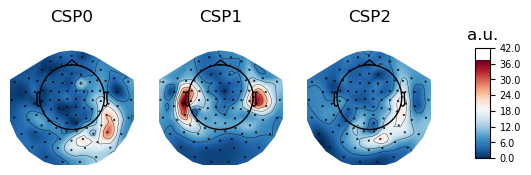

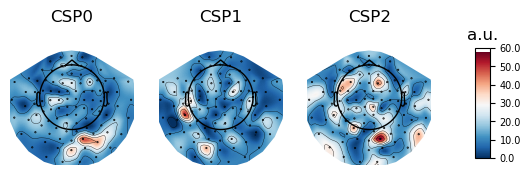

In [23]:
# Fit CSP on full data and plot
csp.fit(X, y)
csp.plot_patterns(epochs.info);
csp.plot_filters(epochs.info, scalings=1e-9);

decoding over time 

In [24]:
# We will train the classifier on all left visual vs auditory trials on MEG

clf = make_pipeline(
    StandardScaler(),
    LogisticRegression(solver='liblinear')
)

time_decod = SlidingEstimator(
    clf, n_jobs=None, scoring='roc_auc', verbose=True)
# here we use cv=3 just for speed
scores = cross_val_multiscore(time_decod, X, y, cv=3, n_jobs=None)

# Mean scores across cross-validation splits
scores = np.mean(scores, axis=0)

# Plot
fig, ax = plt.subplots()
ax.plot(epochs.times, scores, label='score')
ax.axhline(.5, color='k', linestyle='--', label='chance')
ax.set_xlabel('Times')
ax.set_ylabel('AUC')  # Area Under the Curve
ax.legend()
ax.axvline(.0, color='k', linestyle='-')
ax.set_title('Sensor space decoding')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  0%|          | Fitting SlidingEstimator : 0/36 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


  0%|          | Fitting SlidingEstimator : 0/36 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s


  0%|          | Fitting SlidingEstimator : 0/36 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.8s finished


Text(0.5, 1.0, 'Sensor space decoding')

  0%|          | Fitting SlidingEstimator : 0/36 [00:00<?,       ?it/s]

No projector specified for this dataset. Please consider the method self.add_proj.


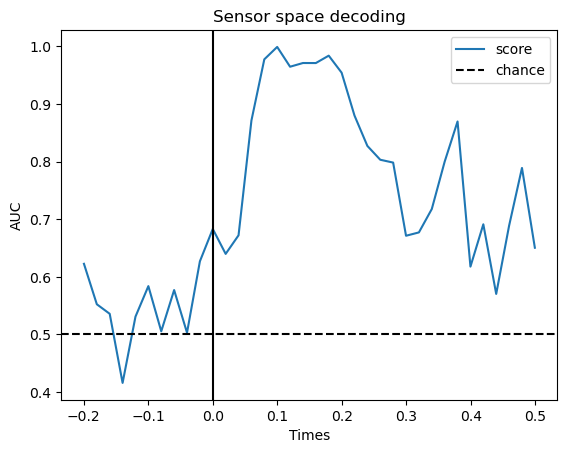

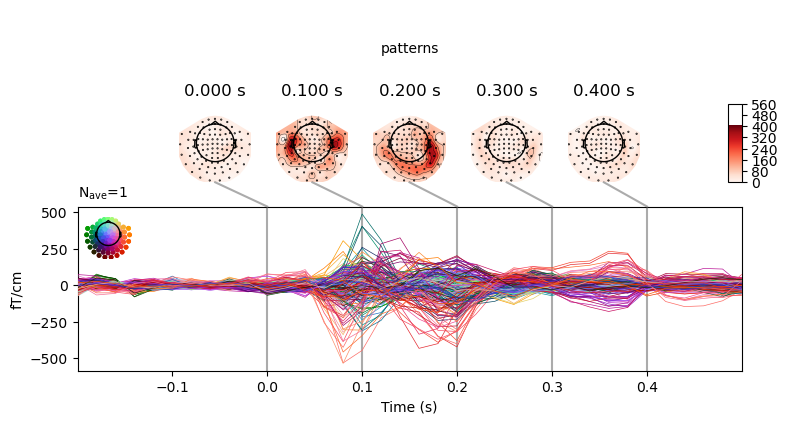

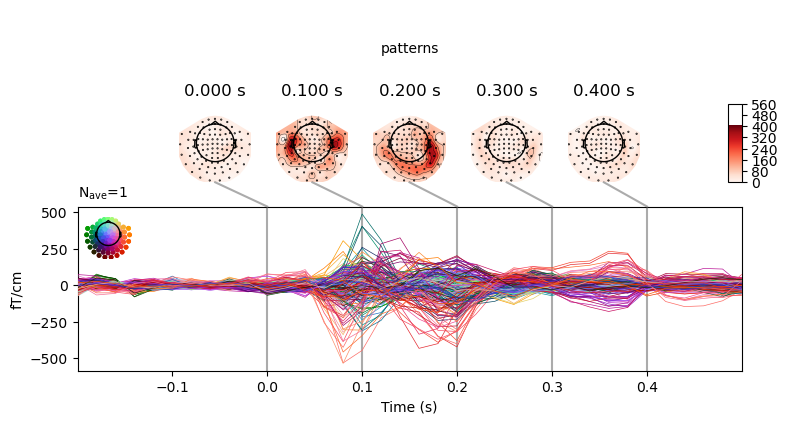

In [25]:
clf = make_pipeline(
    StandardScaler(),
    LinearModel(LogisticRegression(solver='liblinear'))
)
time_decod = SlidingEstimator(
    clf, n_jobs=None, scoring='roc_auc', verbose=True)
time_decod.fit(X, y)

coef = get_coef(time_decod, 'patterns_', inverse_transform=True)
evoked_time_gen = mne.EvokedArray(coef, epochs.info, tmin=epochs.times[0])
joint_kwargs = dict(ts_args=dict(time_unit='s'),
                    topomap_args=dict(time_unit='s'))
evoked_time_gen.plot_joint(times=np.arange(0., .500, .100), title='patterns',
                           **joint_kwargs)

### temporal generalization

In [26]:
# define the Temporal generalization object
time_gen = GeneralizingEstimator(clf, n_jobs=None, scoring='roc_auc',
                                 verbose=True)

# again, cv=3 just for speed
scores = cross_val_multiscore(time_gen, X, y, cv=3, n_jobs=None)

# Mean scores across cross-validation splits
scores = np.mean(scores, axis=0)

# Plot the diagonal (it's exactly the same as the time-by-time decoding above)
fig, ax = plt.subplots()
ax.plot(epochs.times, np.diag(scores), label='score')
ax.axhline(.5, color='k', linestyle='--', label='chance')
ax.set_xlabel('Times')
ax.set_ylabel('AUC')
ax.legend()
ax.axvline(.0, color='k', linestyle='-')
ax.set_title('Decoding MEG sensors over time')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  0%|          | Fitting GeneralizingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/1296 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.4s remaining:    0.0s


  0%|          | Fitting GeneralizingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/1296 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   10.4s remaining:    0.0s


  0%|          | Fitting GeneralizingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/1296 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   15.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   15.6s finished


Text(0.5, 1.0, 'Decoding MEG sensors over time')

In [27]:
fig, ax = plt.subplots(1, 1)
im = ax.imshow(scores, interpolation='lanczos', origin='lower', cmap='RdBu_r',
               extent=epochs.times[[0, -1, 0, -1]], vmin=0., vmax=1.)
ax.set_xlabel('Testing Time (s)')
ax.set_ylabel('Training Time (s)')
ax.set_title('Temporal generalization')
ax.axvline(0, color='k')
ax.axhline(0, color='k')
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('AUC')

In [29]:
# projecting sensor-space patterns to soure space

cov = mne.compute_covariance(epochs, tmax=0.)
del epochs
fwd = mne.read_forward_solution(
    meg_path / 'sample_audvis-meg-eeg-oct-6-fwd.fif')
inv = mne.minimum_norm.make_inverse_operator(
    evoked_time_gen.info, fwd, cov, loose=0.)
stc = mne.minimum_norm.apply_inverse(evoked_time_gen, inv, 1. / 9., 'dSPM')
del fwd, inv

Computing rank from data with rank=None
    Using tolerance 3.1e-10 (2.2e-16 eps * 203 dim * 7e+03  max singular value)
    Estimated rank (grad): 203
    GRAD: rank 203 computed from 203 data channels with 0 projectors
Reducing data rank from 203 -> 203
Estimating covariance using EMPIRICAL
Done.
Number of samples used : 1353
[done]
Reading forward solution from /Users/DanDan/mne_data/MNE-sample-data/MEG/sample/sample_audvis-meg-eeg-oct-6-fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523) not available
    Read MEG forward solution (7498 sources, 306 channels, free orientations)
    Desired named matrix (kind = 3523) not available
    Read EEG forward solution (7498 sources, 60 channels

Using notebook 3d backend.

Using control points [1.98776221 2.41838256 8.06628582]


<IPython.core.display.Javascript object>


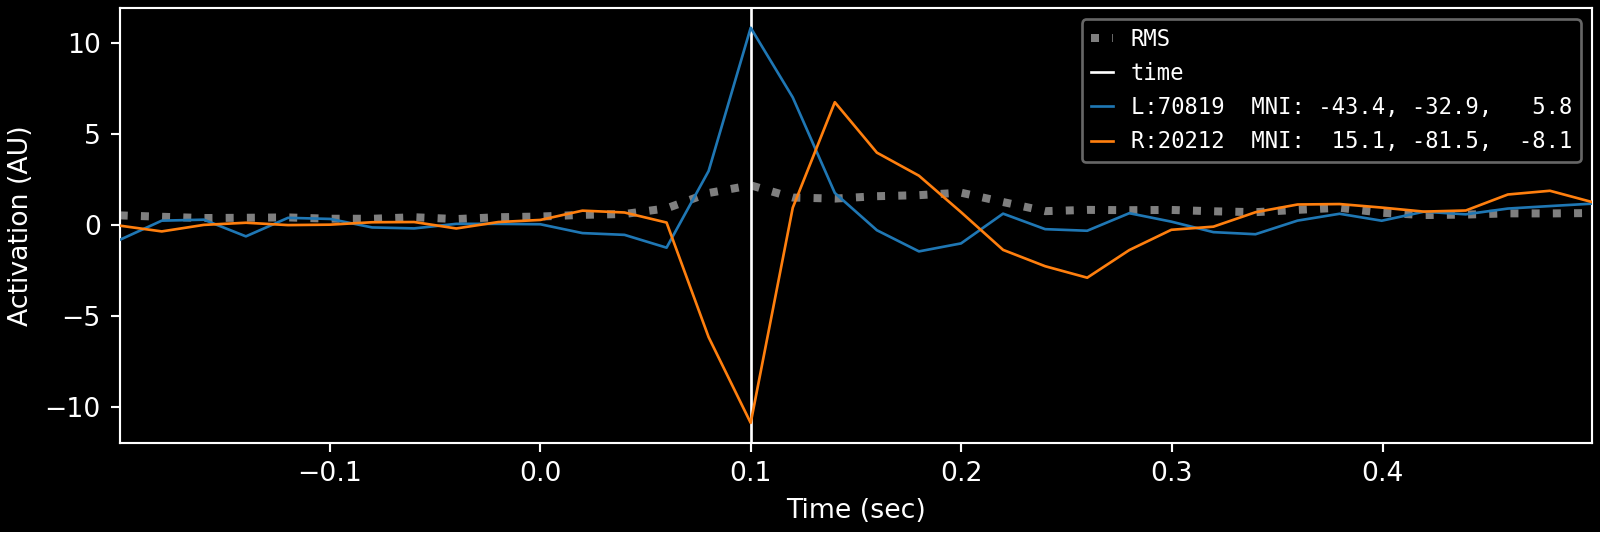

In [30]:
brain = stc.plot(hemi='split', views=('lat', 'med'), initial_time=0.1,
                 subjects_dir=subjects_dir)